<a href="https://colab.research.google.com/github/IA-DAMA/MIT-DeepLearning/blob/main/Part2_FaceDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# *Copyright Information*



*   *Copyright 2023 MIT Introduction to Deep Learning. All Rights Reserved.*
*   *Licensed under the MIT License. You may not use this file except in compliance with the License. Use and/or modification of this code outside of MIT Introduction to Deep Learning must reference:*
*   *© MIT Introduction to Deep Learning*
*   *http://introtodeeplearning.com - Lab: https://github.com/aamini/introtodeeplearning/blob/master/lab2/Part2_FaceDetection.ipynb*
*   *Solved by Damadori which the solution can be found in https://github.com/IA-DAMA/MIT-DeepLearning/tree/main*




grid_0_3.avif

# *Laboratory 2: Computer Vision*

# *Part 2: Diagnosing Bias in Facial Detection Systems*


**In this lab, we'll explore a prominent aspect of applied deep learning for computer vision:**


# *Facial Detection*

*Consider the task of facial detection: given an image, is it an image of a face? This seemingly simple -- but extremely important and pervasive -- task is subject to significant amounts of algorithmic bias among select demographics, as `seminal studies` have shown as on the following link: `https://proceedings.mlr.press/v81/buolamwini18a/buolamwini18a.pdf` .*

*Deploying fair, unbiased AI systems is critical to their long-term acceptance. In this lab, we will build computer vision models for facial detection. We will extend beyond that to build a model to uncover and diagnose the biases and issues that exist with standard facial detection models. To do this, we will build a semi-supervised variational autoencoder (SS-VAE) that learns the latent distribution of features underlying face image datasets in order to `uncover hidden biases` which you is dispicted on the following link: `http://introtodeeplearning.com/AAAI_MitigatingAlgorithmicBias.pdf`*

In [1]:
# Let's get started by installing the relevant dependencies:

import tensorflow as tf

import IPython
import functools
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

# Download and import the MIT Introduction to Deep Learning package

!pip install mitdeeplearning
import mitdeeplearning as mdl

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 8.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for mitdeeplearning: filename=mitdeeplearning-0.3.0-py3-none-any.whl size=2117302 sha256=67ad2f4ba498e661dee0defd5a3eb55bda70a47ccce723fbbb457f6ba7c95269
  Stored in directory: /root/.cache/pip/wheels/9c/9f/b5/0e31f83bc60a83625e37429f923934e26802d0d68cf3ef3216
Successfully built mitdeeplearning


# *2.1 Datasets*

*In order to train our facil detection models, we nee a dataset of positive and negative examples of facial images for classification*



1.   **Positive training data:**  `http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html`  *A large-scale dataset (over 200K images) of celebrity faces.*

2.   **Negative training data:**  `https://image-net.org`  *A large-scale dataset with many images across many different categories*




*We'll evaluate trained models on an independent test dataset of face images to diagnose potential issues with `bias`, `fairness`, and `confidence`.*

*Let's begin by importing these datasets. We've written a class that does a bit of data pre-processing to import the training data in a usable format.*

In [2]:
# Get the training data: both images from CelebA and ImageNet
path_to_training_data = tf.keras.utils.get_file('train_face.h5', 'https://www.dropbox.com/s/hlz8atheyozp1yx/train_face.h5?dl=1')

# Instantiate a TrainingDatasetLoader using the downloaded dataset
loader = mdl.lab2.TrainingDatasetLoader(path_to_training_data)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


1263889489/1263889489 [==============================] - 19s 0us/step
Opening /root/.keras/datasets/train_face.h5
Loading data into memory...


*Let's grab a batch of size 100:*

In [3]:
number_of_training_examples = loader.get_train_size()
(images, labels) = loader.get_batch(100)

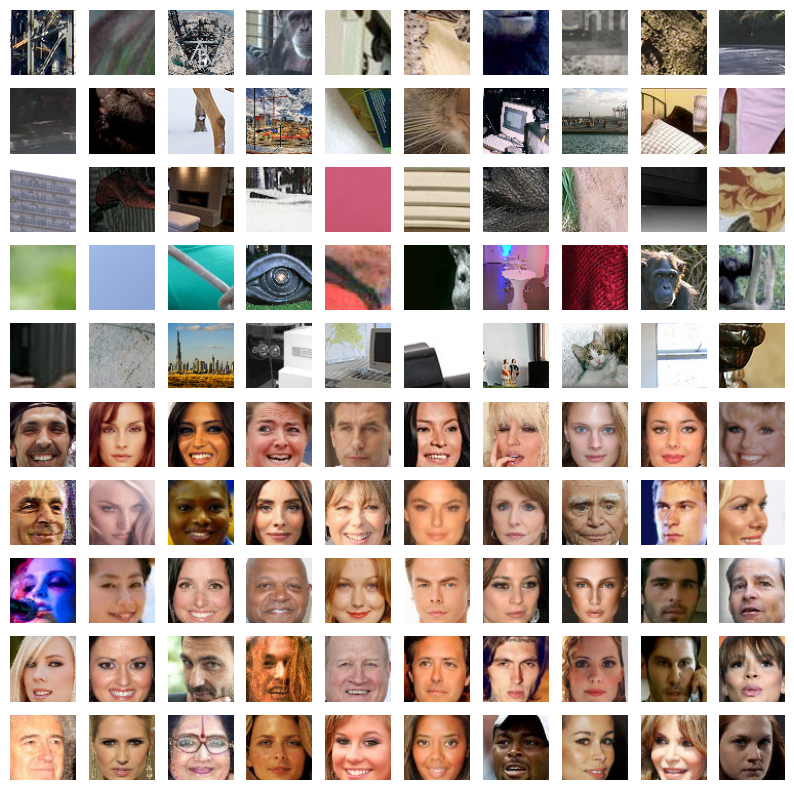

In [4]:
plt.figure(figsize=(10, 10))
for i in range(100):
    plt.subplot(10, 10, i + 1)
    plt.imshow(images[i])
    plt.axis("off")

*Displaying images so that we can realize what the training data looks like:*

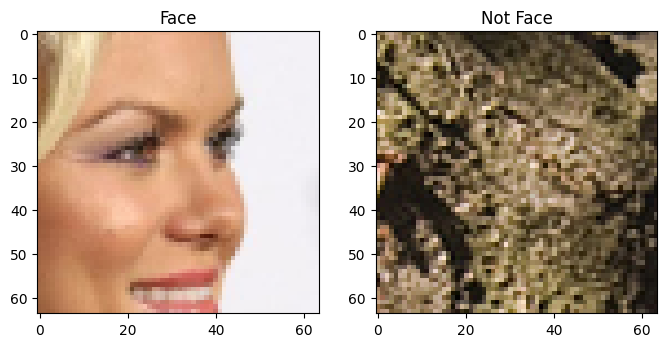

In [5]:
#@title *Change the sliders to look at positive and negative training examples.* { run: "auto" }

### Examining the CelebA training dataset ###


face_images = images[np.where(labels==1)[0]]
not_face_images = images[np.where(labels==0)[0]]

idx_face = 19  #@param {type: "slider", min:0, max:50, step:1}
idx_not_face = 8  #@param {type: "slider", min:0, max:50, step:1}

plt.figure(figsize=(8,4))
plt.subplot(1, 2, 1)
plt.imshow(face_images[idx_face])
plt.title("Face"); plt.grid(False)

plt.subplot(1, 2, 2)
plt.imshow(not_face_images[idx_not_face])
plt.title("Not Face"); plt.grid(False)

**Note**: *It's a classifier `biased` if its classification decision changes after it sees some additional latent features or variables and for a deeper understanding you may want ot read a bit of it on https://en.wikipedia.org/wiki/Latent_and_observable_variables, `latent variables`*

# *2.2 CNN for facial detection*

*Define and train a baseline CNN on the facial detection task of classifying whether a given image is a face, or is not a face.*

*The CNN model has a relatively standard architecture consisting of a series of convolutional layers with batch normalization followed by two fully connected layers to flatten the convolution output and generate a class prediction.*

# *Define and train the CNN model*



*After defining the our CNN model, then we'll train on the `CelebA` and `ImageNet` datasets using the `tf.GradientTape` class and the `tf.GradientTape.gradient method.`*

In [6]:
### Define the CNN model ###

n_filters = 12  #  Base number of convolutional filters

### Function to define a standard CNN model ###

def make_standard_classifier(n_outputs=1):
  Conv2D = functools.partial(tf.keras.layers.Conv2D, padding='same', activation='relu')
  BatchNormalization = tf.keras.layers.BatchNormalization
  Flatten = tf.keras.layers.Flatten
  Dense = functools.partial(tf.keras.layers.Dense, activation='relu')

  model = tf.keras.Sequential([
    Conv2D(filters=1*n_filters, kernel_size=5, strides=2),
    BatchNormalization(),

    Conv2D(filters=2*n_filters, kernel_size=5, strides=2),
    BatchNormalization(),

    Conv2D(filters=4*n_filters, kernel_size=3, strides=2),
    BatchNormalization(),

    Conv2D(filters=6*n_filters, kernel_size=3, strides=2),
    BatchNormalization(),

    Flatten(),
    Dense(512),
    Dense(n_outputs, activation=None),
  ])

  return model

standard_classifier = make_standard_classifier()

# *Training the standard CNN*

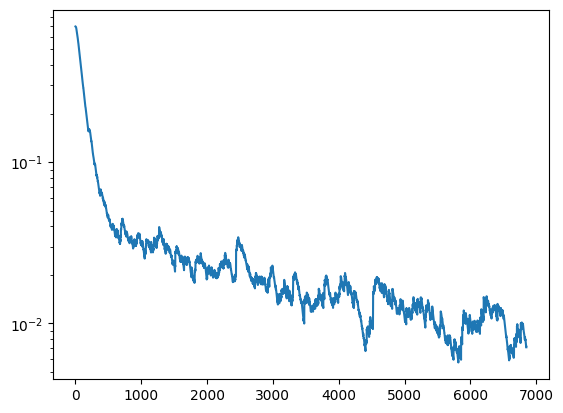

100%|██████████| 3434/3434 [05:06<00:00, 11.22it/s]


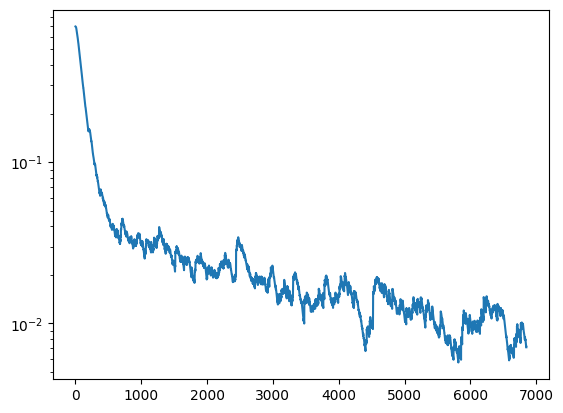

In [7]:
# Training hyperparameters
batch_size = 32
num_epochs = 2   # Keep small to run faster
learning_rate = 5e-4

optimizer = tf.keras.optimizers.Adam(learning_rate)
loss_history = mdl.util.LossHistory(smoothing_factor=0.99)
plotter = mdl.util.PeriodicPlotter(sec=2, scale='semilogy')
if hasattr(tqdm, '_instances'): tqdm._instances.clear()

@tf.function
def standard_train_step(x, y):
  with tf.GradientTape() as tape:
    # feed the images into the model
    logits = standard_classifier(x)
    # Compute the loss
    loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=y, logits=logits)

  # Backpropagation
  grads = tape.gradient(loss, standard_classifier.trainable_variables)
  optimizer.apply_gradients(zip(grads, standard_classifier.trainable_variables))
  return loss

# The training loop
for epoch in range(num_epochs):
  for idx in tqdm(range(loader.get_train_size()//batch_size)):

    # Grab a batch of training data and propagate through the network
    x, y = loader.get_batch(batch_size)
    loss = standard_train_step(x, y)

    # Record the loss and plot the evolution of the loss as a function of training
    loss_history.append(loss.numpy().mean())
    plotter.plot(loss_history.get())

*Notice the graph right above will run twice as we determined `epochs=2`*

# *Evaluate performance of the standard CNN*

*Down bellow we'll evaluate the classification performance of CelebA-trained standard CNN on the training dataset*

In [8]:
### Evaluation of standard CNN ###

# Evaluate on a subset of CelebA+Imagenet

(batch_x, batch_y) = loader.get_batch(5000)
y_pred_standard = tf.round(tf.nn.sigmoid(standard_classifier.predict(batch_x)))
acc_standard = tf.reduce_mean(tf.cast(tf.equal(batch_y, y_pred_standard), tf.float32))

print("Standard CNN accuracy on (potentially biased) training set: {:.4f}".format(acc_standard.numpy()))

157/157 [==============================] - 5s 29ms/step
Standard CNN accuracy on (potentially biased) training set: 0.9984


# *2.3 Diagnosing algorithmic bias*

*The `CNN` we've built so far is the standard solution for facil detection pipelines throughout society. Despite their pervasiveness, these models suffer from amounts of algorithmic bias, obviously due to how society has fed dataset benchmarks all over the world, for economic and political reasons (Let's be straight here). It has a broad approach as we may notice on following article by `Buolamwini and Gebru`: https://proceedings.mlr.press/v81/buolamwini18a/buolamwini18a.pdf*

# Determining the Source of these biases



*   **Naive approach**: *This would annotate different subclasses within the training data, then evaluate classifier performance with respect to these groups. However, such aproach presents two mayor disadvantages. `First: It requires massive amounts of data that is not scalable and second it requires our awareness of potentital biases to look for in the data such as race, gender, pose, occlusion, hats, glasses, etc`*

*   **Automatically uncovering hidden biases**:  *Imbalances in the training data can result in unwanted algorithmic bias. For example, the majority of faces in `CelebA` (our training set) are those of light-skinned females. So why? Economy and politics in the end.*



# *2.4 Variational autoenconder (VAE) for learning latent structure*

*Our goal here is to overcome the problem we have just approached by training our model that `learns a representation of the underlying latent space` to the face training data and the `key design` for the model is that it can learn an `encoding` of the latent features in the face data in an entirely `unsupervided` way, without any annotation by no humans. To achieve it, we'll turn to variational autoencoders (VAEs).*

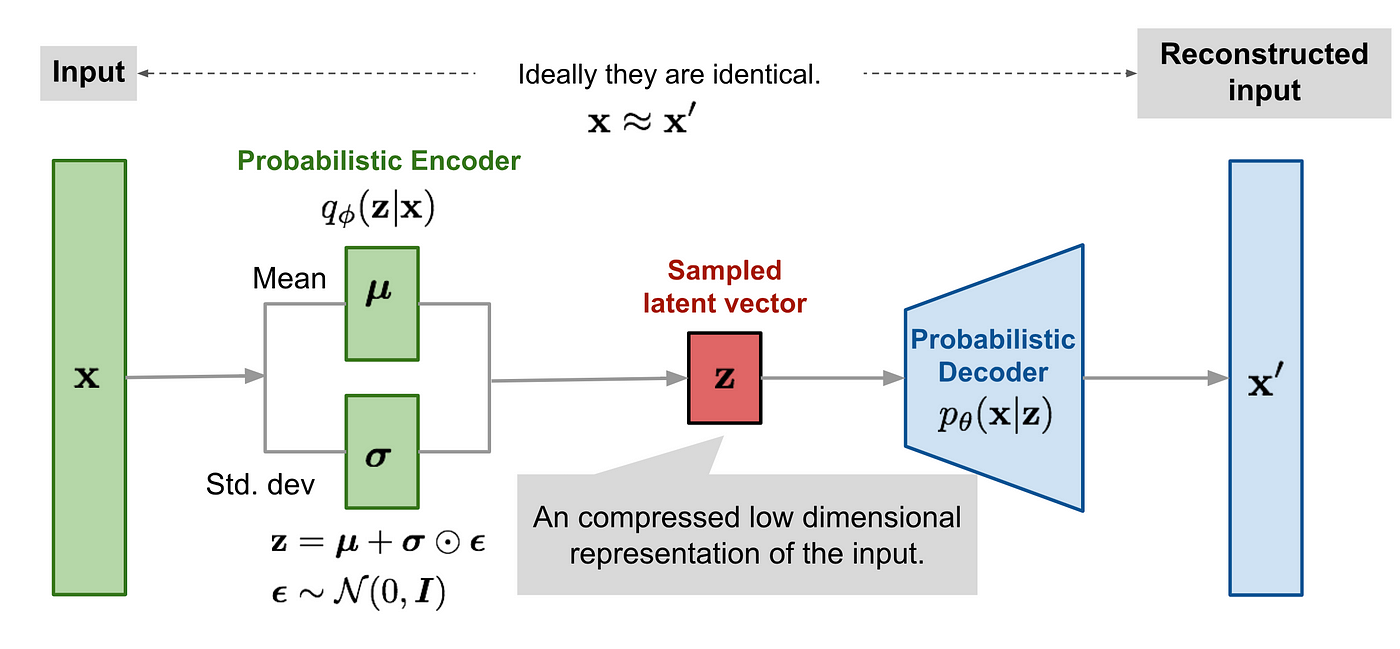

*For more, see MIT 6.S191: Deep Generative Modeling, lecture 4 in the following link: https://www.youtube.com/watch?v=3G5hWM6jqPk&t=167s*

# *Understanding VAEs: loss function*

*In learning the latent space, we constrain the means and standard deviations to follow a `unit Gaussian`. As these are learned parameters, it must factor into the loss computation, and that the decoder portion of the VAE is using these parameters to output a reconstruction that should closely match the input image, which also must factor into the loss. Then we'll have two terms in our `VAE loss function`:*






1.   **Latent loss** (L<sub>KL</sub>): *how closely latent variables match a unit Gaussian and is defined by the `Kullback-Leibler (KL) divergence.`*


2.   **Reconstruction loss** (L<sub>x</sub>(x, x̂): *how accurately the reconstructed outputs match the input and is given by the L<sup>1</sup> norm of the input image and its recpnstructed output.*



*The equation for the `latent loss` is provided by:*

- *L*<sub>*KL*</sub>($\mu$
,$\sigma$
) = $\frac{1}{2}$ $\sum_{j=0}^{k-1}$ ($\sigma$
<sub>*j*</sub> + $μ_{j}^{2}$ - 1 - log $\sigma$<sub>*j*</sub>)

*The equation for the `reconstruction loss` is provided by:*

- *L*<sub>$x$</sub>($x$, $\hat{x}$) = ||$x$-$\hat{x}$||<sub>1</sub>


*Thus for the `VAE loss` we have:*

- *L*<sub>*VAE*</sub> = $c$ &middot; *L*<sub>*KL*</sub> + *L*<sub>$x$</sub>($x$, $\hat{x}$)

*Where* $c$ *is a weighting coefficient used for regularization.*

# *VAE loss function*

*Consider the equations within the block above*

In [9]:
### Defining the VAE loss function ###

''' Function to calculate VAE loss given:
      an input x,
      reconstructed output x_recon,
      encoded means mu,
      encoded log of standard deviation logsigma,
      weight parameter for the latent loss kl_weight
'''

def vae_loss_function(x, x_recon, mu, logsigma, kl_weight=0.0005):
  # Define the latent loss. This is given by the LKL equation above.
  latent_loss = 0.5 * tf.reduce_sum(tf.exp(logsigma) + tf.square(mu) - 1.0 - logsigma, axis=1)
  latent_loss = tf.reduce_mean(latent_loss)

  # Define the reconstruction loss as the mean absolute pixel-wise
  # difference between the input and reconstruction.
  # reconstruction_loss = tf.reduce_mean(tf.abs(x - x_recon))
  reconstruction_loss = tf.reduce_mean(tf.abs(x-x_recon), axis=(1,2,3))

  # Define the total VAE loss, which is a combination of the latent loss and the reconstruction loss.
  vae_loss = kl_weight * latent_loss + reconstruction_loss

  return vae_loss

# *VAEs: sampling and reparameterization*

*VAEs use a "reparameterization trick" which consistis on generating a vector of means and a vector of standard deviations (Considering Gaussian distributions). Then sampling a noise value ∈ from Gaussian distribution, then scale it by the standard deviation and add back the mean to output result as the sampled vector. Formalizing this for a latent variable* $z$  *where we sample* ∈ ~ *N*(0,(*I*)) *so we have* :


- $z$ $=$ $\mu$ $+$ $e$ <sup>($\frac{1}{2}$ &middot; log $\sum$)</sup> $\circ$ ∈

*where $\mu$ is the mean and $\sum$ is the covariance matrix. This will help us:*

* *Define `loss function`for teh VAE*
* *Generate randomly sampled latent variables*
* *Achieve improved network generalization*
* *Make VAE network differentiable so that it can be trained via backpropagation*

# *VAE sampling operation*

*In this code, the reparameterization trick is implemented by computing z using the provided formula* $z$ $=$ $\mu$ + $σ$ * ε. *Here, `z_mean` is the mean of the latent distribution, `z_logsigma` is the logarithm of the standard deviation, and ε is a random sample from a standard Gaussian distribution*

In [10]:
### VAE Sampling ###

def sampling(z_mean, z_logsigma):
  # By default, random.normal is "standard" (ie. mean=0 and std=1.0)
  batch, latent_dim = z_mean.shape
  epsilon = tf.random.normal(shape=(batch, latent_dim))

  # Reparameterization trick: z = μ + σ * ε
  # z = z_mean + tf.exp(0.5 * z_logsigma) * epsilon
  z = z_mean + tf.math.exp(0.5 * z_logsigma) * epsilon

  return z

# *2.5 Semi-supervised variational autoencoder (SS-VAE)*

* *We'll work on this network structure to diagnoses hidden biases in facial detection classifiers:*

* "*This draws direct inspiration from a recent paper proposing this as a general approach for automatic bias detetion and mitigation*". *This paper can be found on the following:* *http://introtodeeplearning.com/AAAI_MitigatingAlgorithmicBias.pdf*


# *Semi-supervised VAE architecture*

*While works like that of Buolamwini and Gebru have focused on skin tone and gender as approached ealier on this lab, there may be other unlabeled features that are also biased.*

* *So we're going to build a semi-supervised VAE (SS-VAE) to learn such underlying latent features.*

* *We can see what SS-VAE architecture looks like down bellow:*


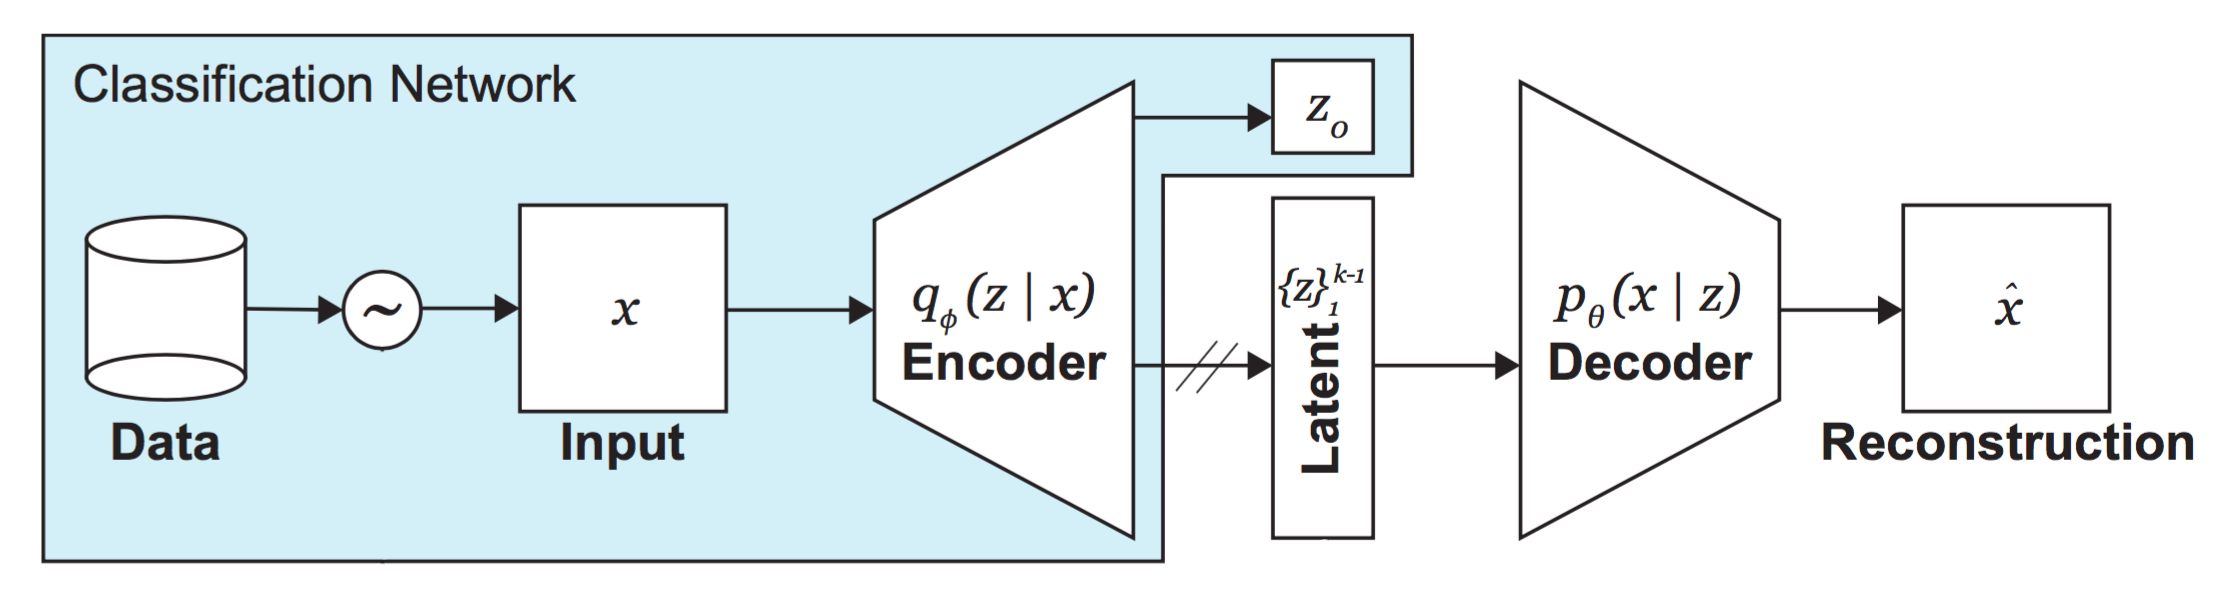


*This SS-VAE model both learns a representation of the unsupervised latent variables, captured by distribution* $q$<sub>$\Phi$</sub>($z$|$x$), *and outputs a supervised class prediction* $z$<sub>$\circ$</sub>, *but that, for negative examples, it only outputs a class prediction* $z$<sub>$\circ$</sub>.

# *Defining the SS-VAE loss function*

*For `face images`, our loss function has two components:*

* VAE loss (*L*<sub>*VAE*</sub>):  *Consists of the latent loss and the reconstruction loss.*
* Classification loss (*L*<sub>y</sub>($y$, $\hat{y}$)):  *Standard cross-entropy loss for a binary classification problem.*

*In constrat, for images of non-faces, our loss function is  solely the classification loss.*

*We'll set a single expression for the loss by defining an indicator variable I*<sub>*f*</sub> *which reflects which training data are images of faces* (*I*<sub>*f*</sub>($y$) $=$ 1) *and which are images of non-faces* (*I*<sub>*f*</sub>($y$) $=$ 0).  *Using this to obtain:*

* *L*<sub>total</sub> $=$ *L*<sub>$y$</sub>($y$, $\hat{y}$) $+$ *I*<sub>*f*</sub>($y$)$[$*L*<sub>*VAE*</sub>$]$

# *Loss function for SS-VAE*

*The vae_loss_function is assumed to be defined previously and is called within the `ss_vae_loss_function`. The classification loss is calculated using `tf.nn.sigmoid_cross_entropy_with_logits`. The face_indicator is used to determine whether to include the VAE loss component for face images. The SS-VAE total loss is calculated as a combination of `classification loss` and `VAE loss for face images`, while for non-face images, only the classification loss is considered.*

In [11]:
### Loss function for SS-VAE ###

"""Loss function for SS-VAE.
# Arguments
    x: true input x
    x_pred: reconstructed x
    y: true label (face or not face)
    y_logit: predicted labels
    mu: mean of latent distribution (Q(z|X))
    logsigma: log of standard deviation of latent distribution (Q(z|X))
# Returns
    total_loss: SS-VAE total loss
    classification_loss: SS-VAE classification loss
"""

def ss_vae_loss_function(x, x_pred, y, y_logit, mu, logsigma):

  # Call the vae_loss_function to calculate VAE loss
  vae_loss = vae_loss_function(x, x_pred, mu, logsigma)

  # Define the classification loss using sigmoid_cross_entropy
  classification_loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=y, logits=y_logit)

  # Use the training data labels to create the face_indicator
  face_indicator = tf.cast(tf.equal(y, 1), tf.float32)

  # Define the SS-VAE total loss
  # Loss for images of non-faces will be only the classification loss
  total_loss = tf.reduce_mean(classification_loss + face_indicator * vae_loss)

  return total_loss, classification_loss, vae_loss

# *Defining the SS-VAE architecture*



*Now, we'll use the standard CNN classifier from above as our encoder and define a decoder network. So we'll `create and initialize`the encoder and encoder networks, and then construct the `end-to-end VAE`. So using a latent space with `32 latent variables`.*

* *The decoder network will take as input the sampled latent variables, run them through a series of `deconvolutional layers`, and output a reconstruction of the original input image.*

In [12]:
### Define the decoder portion of the SS-VAE ###

def make_face_decoder_network(n_filters=12):

  # Functionally define the different layer types we will use

  Conv2DTranspose = functools.partial(tf.keras.layers.Conv2DTranspose, padding='same', activation='relu')
  BatchNormalization = tf.keras.layers.BatchNormalization
  Flatten = tf.keras.layers.Flatten
  Dense = functools.partial(tf.keras.layers.Dense, activation='relu')
  Reshape = tf.keras.layers.Reshape

  # Build the decoder network using the Sequential API

  decoder = tf.keras.Sequential([

    # Transform to pre-convolutional generation

    Dense(units=4*4*6*n_filters),  # 4x4 feature maps (with 6N occurances)
    Reshape(target_shape=(4, 4, 6*n_filters)),

    # Upscaling convolutions (inverse of encoder)

    Conv2DTranspose(filters=4*n_filters, kernel_size=3,  strides=2),
    Conv2DTranspose(filters=2*n_filters, kernel_size=3,  strides=2),
    Conv2DTranspose(filters=1*n_filters, kernel_size=5,  strides=2),
    Conv2DTranspose(filters=3, kernel_size=5,  strides=2),
  ])

  return decoder

*We'll put this `decoder` together with the standar CNN classifier as our encoder to define the `SS-VAE`. Then defining the `core VAE architecture` by subclassing the `Model`class;*

* *Defining encoding*
* *Sampling*
* *Decoding operations*
* *Calling the network end-to-end*

In [13]:
### Defining and creating the SS-VAE ###

class SS_VAE(tf.keras.Model):
  def __init__(self, latent_dim):
    super(SS_VAE, self).__init__()
    self.latent_dim = latent_dim

    # Define the number of outputs for the encoder.
    # Recall that we have latent_dim latent variables,
    # as well as a supervised output for the classification

    num_encoder_dims = 2*self.latent_dim + 1

    self.encoder = make_standard_classifier(num_encoder_dims)
    self.decoder = make_face_decoder_network()

  # Function to feed images into encoder, encode the latent space, and output classification probability
  def encode(self, x):
    encoder_output = self.encoder(x)

    # Classification prediction
    y_logit = tf.expand_dims(encoder_output[:, 0], -1)

    # Latent variable distribution parameters
    z_mean = encoder_output[:, 1:self.latent_dim + 1]
    z_logsigma = encoder_output[:, self.latent_dim + 1:]

    return y_logit, z_mean, z_logsigma

  # Decode the latent space and output reconstruction
  def decode(self, z):
    reconstruction = self.decoder(z)
    return reconstruction

  # The call function will be used to pass inputs x through the core VAE
  def call(self, x):

    # Encode input to a prediction and latent space
    y_logit, z_mean, z_logsigma = self.encode(x)

    # Call the sampling function
    z = sampling(z_mean, z_logsigma)

    # Decode the latent space
    recon = self.decode(z)

    return y_logit, z_mean, z_logsigma, recon

  # Predict face or not face logit for given input x
  def predict(self, x):
    y_logit, z_mean, z_logsigma = self.encode(x)
    return y_logit

# Create the SS_VAE model instance
ss_vae = SS_VAE(latent_dim=32)

*The encoder architecture is identical to the CNN from earlier in this lab. The note the outputs of our constructed SS-VAE model in the `call` function: `y_logit, z_mean, z_logsigma, z` which must be carefully considered.*

# *Training the SS-VAE*

Starting epoch 6/6


  0%|          | 0/3434 [00:00<?, ?it/s]

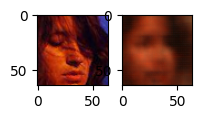

 15%|█▍        | 500/3434 [01:12<06:32,  7.48it/s]

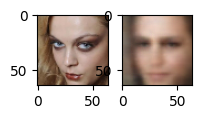

 29%|██▉       | 1000/3434 [02:28<05:10,  7.83it/s]

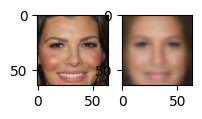

 44%|████▎     | 1500/3434 [03:39<04:13,  7.62it/s]

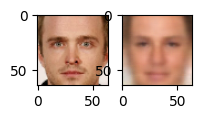

 58%|█████▊    | 2000/3434 [04:52<04:13,  5.66it/s]

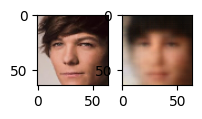

 73%|███████▎  | 2500/3434 [06:05<01:58,  7.86it/s]

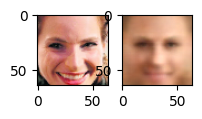

 87%|████████▋ | 3000/3434 [07:18<01:09,  6.21it/s]

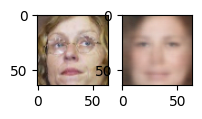

100%|██████████| 3434/3434 [08:23<00:00,  6.82it/s]


In [14]:
### Training the SS-VAE ###

# Hyperparameters
batch_size = 32
learning_rate = 5e-4
latent_dim = 32

# Note SS-VAE needs slightly more epochs to train since it's more complex than
# the standard classifier, so we use 6 instead of 2
num_epochs = 6

# Instantiate a new SS-VAE model and optimizer
ss_vae = SS_VAE(latent_dim)
optimizer = tf.keras.optimizers.Adam(learning_rate)

# To define the training operation, we will use tf.function which is a powerful tool
# that lets us turn a Python function into a TensorFlow computation graph.

@tf.function
def ss_vae_train_step(x, y):
    with tf.GradientTape() as tape:
        # Feed input x into ss_vae. Note that this is using the SS_VAE call function!
        y_logit, z_mean, z_logsigma, x_recon = ss_vae(x)

        # Call the SS_VAE loss function to compute the loss
        loss, class_loss, _ = ss_vae_loss_function(x, x_recon, y, y_logit, z_mean, z_logsigma)

    # Compute the gradients with respect to trainable_variables of the SS_VAE
    grads = tape.gradient(loss, ss_vae.trainable_variables)

    # Apply gradients to variables
    optimizer.apply_gradients(zip(grads, ss_vae.trainable_variables))

    return loss


# Get training faces from the data loader
all_faces = loader.get_all_train_faces()

if hasattr(tqdm, '_instances'):
    tqdm._instances.clear()  # Clear if it exists

# The training loop -- outer loop iterates over the number of epochs
for i in range(num_epochs):
    IPython.display.clear_output(wait=True)
    print("Starting epoch {}/{}".format(i + 1, num_epochs))

    # Get a batch of training data and compute the training step
    for j in tqdm(range(loader.get_train_size() // batch_size)):
        # Load a batch of data
        (x, y) = loader.get_batch(batch_size)
        # Loss optimization
        loss = ss_vae_train_step(x, y)

        # Plot the progress every 500 steps
        if j % 500 == 0:
            mdl.util.plot_sample(x, y, ss_vae)



*Once `SS-VAE facial classification model` is trained, so it's ready for model evaluation.*

# 2.6 *Using the SS-VAE to uncover and diagnose biases*

*With the SS-VAE model trained, we are ready to use it to uncover and diagnose hidden biases.*

* *The goal with the SS-VAE was to learn the underlying `latent distribution` of features in order to uncover potential disparities taht exist in the data.*

* **Note:** *The VAE reconstruction loss reflects how well the model is able to handle particular input data, the higher the reconstruction, the harder that particular example is for the model to learn.*

*Both aspects are considered to understand sources of uncertainty and bias.*





# *Analysis and reflection*

...

1.   *What, if any, trends do you observe comparing the samples with the highest and lowest reconstruction loss?*
2.   *Based on these observations, which features seemed harder to learn for the VAE?*
3.   *How does reconstruction loss relate to uncertainty? Think back to our lecture on Robust & Trustworthy Deep Learning! What can you say about examples on which the model may be more or less uncertain?*

...







* *The purpose of running the print statements for vae_loss.shape, vae_loss, and ind down bellow is to inspect the values of these variables during the runtime of your code. This can be helpful in diagnosing the issue you might facing with the code.*

In [21]:
print("vae_loss shape:", vae_loss.shape)
print("vae_loss:", vae_loss)
print("ind:", ind)


vae_loss shape: (5000,)
vae_loss: [0.10032798 0.09469561 0.0801448  ... 0.09649358 0.10170522 0.0795453 ]
ind: [4366 2492 4766 ...  747  246  205]


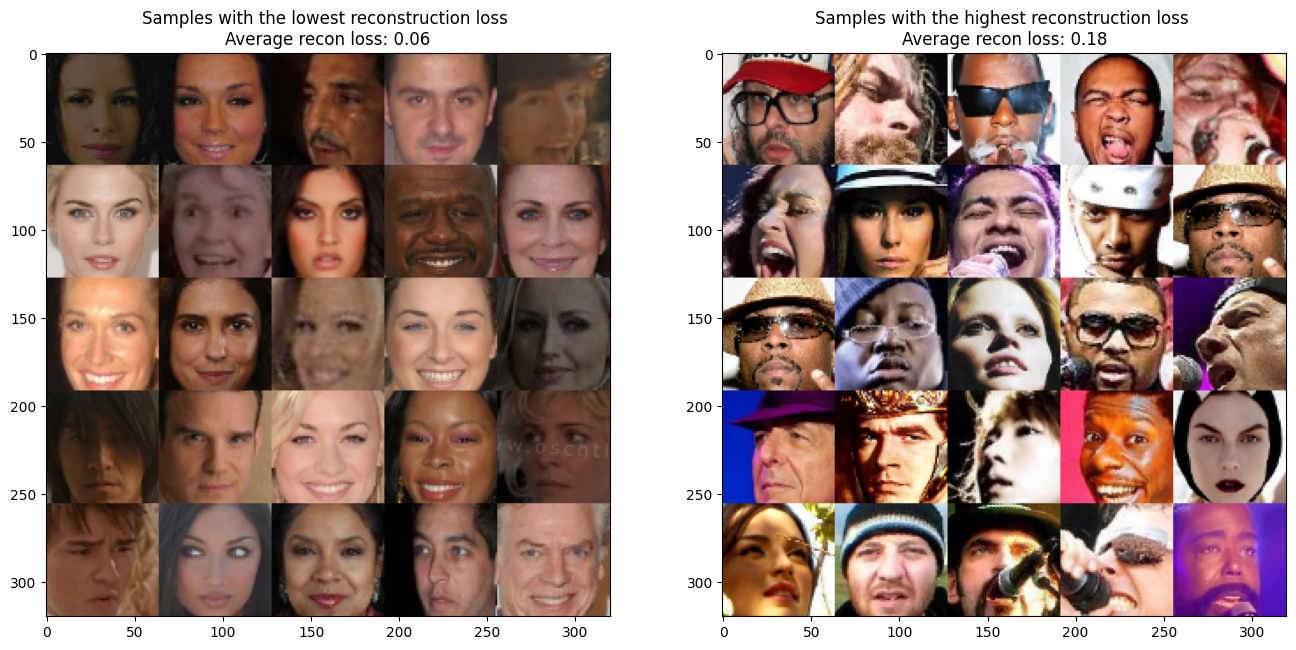

In [17]:
### Linking model performance to uncertainty and bias


# Load a random sample of 5000 faces from our dataset
(x, y) = loader.get_batch(5000, only_faces=True)

# Compute the model performance on the faces
y_logit, z_mean, z_logsigma, x_recon = ss_vae(x)
loss, class_loss, vae_loss = ss_vae_loss_function(x, x_recon, y, y_logit, z_mean, z_logsigma)

# Sort the results by the VAE loss scores
vae_loss = vae_loss.numpy()
ind = np.argsort(vae_loss, axis=None)

# Plot the 25 samples with the lowest reconstruction losses
fig, ax = plt.subplots(1, 2, figsize=(16, 8))
ax[0].imshow(mdl.util.create_grid_of_images(x[ind[:25]]))
ax[0].set_title("Samples with the lowest reconstruction loss \n" +
                f"Average recon loss: {np.mean(vae_loss[ind[:25]]):.2f}")

# Plot the 25 samples with the highest reconstruction losses
ax[1].imshow(mdl.util.create_grid_of_images(x[ind[-25:]]))
ax[1].set_title("Samples with the highest reconstruction loss \n" +
                f"Average recon loss: {np.mean(vae_loss[ind[-25:]]):.2f}");

# Show the plots
plt.show()


# *Uncovering hidden biases through learned latent features*

* *Loss is a powerful way to visualize which samples in our dataset the model has had trouble learning and these examples are those that have high model uncertainty.*

* *How can we determine the relative frequencies and distributions of different latent features learned by the model? How may these metrics reveal underlying biases?*

* *So we'll inspect individual latent features and look at the distribution of these features in the data and their corresponding examples to investigate how well the SS-VAE actually learned the latent features of the faces.*



# *Analysis and futher reflection*

* *1) Pick two latent variables and describe what semantic meaning they reflect. Include screenshots of the realizations and probability distribution for the latent variables you select.*

* *2) For the latent variables selected, what can you tell about which features are under- or over-represented in the data? What might this tell us about how the model is biased?*

* *3) For the latent variables selected, how do these feature distribution differences affect classification performance? What, if any, general trends do you observe across the latent variables?*

* *4) Based on these observations, please describe your understanding of the bias of the facial detection classifier.*

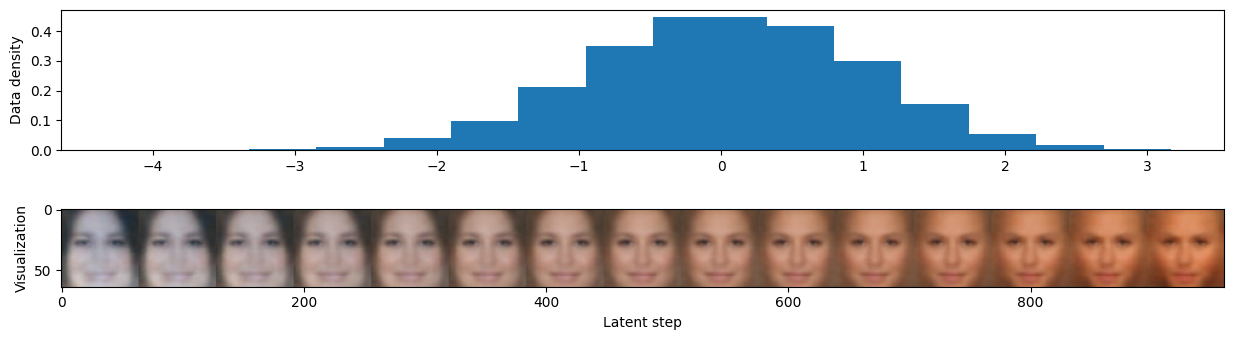

In [18]:
### Inspect different latent features

#@title Change the sliders to inspect different latent features! { run: "auto" }
idx_latent = 8 #@param {type:"slider", min:0, max:31, step:1}
num_steps = 15

# Extract all latent samples from the desired dimension
latent_samples = z_mean[:, idx_latent]

# Compute their density and plot
density, latent_bins = np.histogram(latent_samples, num_steps, density=True)
fig, ax = plt.subplots(2, 1, figsize=(15, 4))
ax[0].bar(latent_bins[1:], density)
ax[0].set_ylabel("Data density")

# Visualize reconstructions as we walk across the latent space
latent_steps = np.linspace(np.min(latent_samples), np.max(latent_samples), num_steps)
baseline_latent = tf.reduce_mean(z_mean, 0, keepdims=True)

recons = []
for step in latent_steps:
  # Adjust the latent vector according to our step
  latent = baseline_latent.numpy()
  latent[0, idx_latent] = step
  # Decode the reconstruction and store
  recons.append(ss_vae.decode(latent)[0])

# Visualize all of the reconstructions!
ax[1].imshow(mdl.util.create_grid_of_images(recons, (1, num_steps)))
ax[1].set_xlabel("Latent step")
ax[1].set_ylabel("Visualization");

# *Inspect how the accuracy changes as a function of density in the latent space*


* *This cell is trying to visualize the relationship between the accuracy of the SS-VAE model and the density of points in the latent space. It aims to show how well the model performs in different regions of the latent space.*

Text(0, 0.5, 'Relative accuracy')

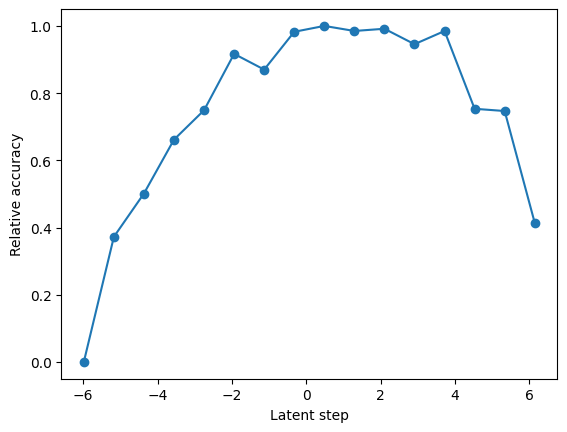

In [19]:
### Accuracy vs. density in latent space

# Loop through every latent dimension
avg_logit_per_bin = []
for idx_latent in range(latent_dim):
  latent_samples = z_mean[:, idx_latent]
  start = np.percentile(latent_samples, 5)
  end = np.percentile(latent_samples, 95)
  latent_steps = np.linspace(start, end, num_steps)

  # Find which samples fall in which bin of the latent dimension
  which_latent_bin = np.digitize(latent_samples, latent_steps)

  # For each latent bin, compute the accuracy (average logit score)
  avg_logit = []
  for j in range(0, num_steps+1):
    inds_in_bin = np.where(which_latent_bin == j)
    avg_logit.append(y_logit.numpy()[inds_in_bin].mean())

  avg_logit_per_bin.append(avg_logit)

# Average the results across all latent dimensions and all samples
accuracy_per_latent = np.mean(avg_logit_per_bin, 0)
accuracy_per_latent = (accuracy_per_latent - accuracy_per_latent.min()) / np.ptp(accuracy_per_latent)

# Plot the results
plt.plot(np.linspace(np.min(z_mean), np.max(z_mean), num_steps+1), accuracy_per_latent,'-o')
plt.xlabel("Latent step")
plt.ylabel("Relative accuracy")


# *2.8 Conclusion:*

# *Linking model performance to uncertainty and bias*

* *What, if any, trends do you observe comparing the samples with the highest and lowest reconstruction loss?*

<font color="orange">*Though an interesting enhencement, the use of acessories (hat, glasses, helmet, etc), skin color, make-ups, ethnicity.*</font>

* *Based on these observations, which features seemed harder to learn for the VAE?*

<font color="orange">*Ethnical biases*</font>

* *How does reconstruction loss relate to uncertainty? Think back to our lecture on Robust & Trustworthy Deep Learning! What can you say about examples on which the model may be more or less uncertain?*

<font color="orange">*In terms of uncertainty, examples in which the model can be more uncertain are those with high reconstruction loss. This usually occurs when the input is complex, ambiguous, or unusual, making it difficult for the model to generate an accurate reconstruction. On the other hand, examples with low reconstruction loss are those where the model feels more confident in recreating the input, as the input fits well with what the model has learned during training.*</font>


# *Uncovering hidden biases through learned latent features*

* *Pick two latent variables and describe what semantic meaning they reflect. Include screenshots of the realizations and probability distribution for the latent variables you select.*

* *For the latent variables selected, what can you tell about which features are under- or over-represented in the data? What might this tell us about how the model is biased?*

<font color="orange">*Skin color and ethnicity*</font>

* *For the latent variables selected, how do these feature distribution differences affect classification performance? What, if any, general trends do you observe across the latent variables?*

<font color="orange">*The prevalence of white skin color and the prevalence of North American and European ethnicity.*</font>

* *Based on these observations, please describe your understanding of the bias of the facial detection classifier.*

<font color="orange">*The over-representation of these features in the data could lead to biased classification performance. For example, if the model is trained on a dataset where white skin color and specific ethnicities are prevalent, it might become more accurate at classifying images with those features while being less accurate for under-represented features. This can result in biased outcomes, where the model might perform well for some groups while performing poorly for others.*</font>

# *2.9 Thinking ahead*

* *How do the samples with highest reconstruction loss and samples with highest bias compare? Which features is each one highlighting? Why do you think this is?*

<font color="orange">*The samples with highest reconstruction loss seem to overcome ethnicity bias by acessories or any blur on the faces. However the prevalent bias of white ethnicity remains*</font>

* *In what ways is the dataset biased so far? Can you imagine other features that the dataset is biased against that we have not uncovered yet?*

<font color="orange">*Ethnicity*</font>

* *How can the performance of the supervised VAE classifier be improved?*

<font color="orange">*By feeding the model with "quota" or "reservations"*</font>

* Do you have ideas for other ways to address issues of bias, particularly in terms of the training data?

<font color="orange">*By feeding the model with "quota" or "reservations" related to skin color and ethnicity, as reserving top and botton limits considering statistics samples and their types*</font>

<img src="https://i.pinimg.com/originals/7c/d5/3d/7cd53d36d121d839da9600ca055b01db.gif" alt="GIF Example" width="700">
